In [1]:
import numpy as np
import pandas as pd

# Decision Tree

In [2]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

    
def create_leaf(data, ml_task):
    
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
      
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf

def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1): # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        unique_values = np.sort(unique_values)
        arr=[]
        for i in range(len(unique_values)-1):
            arr.append((unique_values[i] + unique_values[i+1])/2)
        unique_values = arr
        
        
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse


def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric


def determine_best_split(data, potential_splits, ml_task):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            
            # classification
            else:
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "g":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types


def decision_tree_algorithm(df, ml_task, counter=0, min_samples=2, max_depth=5):
    
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    else:    
        counter += 1

         
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        
        
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        
        
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        
        sub_tree = {question: []}
        
        
        yes_answer = decision_tree_algorithm(data_below, ml_task, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, ml_task, counter, min_samples, max_depth)
        
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree



def predict_example(example, tree):
    
    
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    
    if not isinstance(answer, dict):
        return answer
    
    
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

    

def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_example, args=(tree,), axis=1)
    else:
        predictions = pd.Series()
        
    return predictions


def calculate_accuracy(df, tree):
    predictions = make_predictions(df, tree)
    predictions_correct = predictions == df.g
    accuracy = predictions_correct.mean()
    
    return accuracy

In [3]:
df = pd.read_csv("dataset.csv")

In [4]:
training_accuracy = []

for i in range (1, 12):
  tree = decision_tree_algorithm(df.iloc[:90, :], "classification", counter=0, min_samples=2, max_depth=i)
  act = calculate_accuracy(df.iloc[:90, :], tree)
  training_accuracy.append(act)

In [5]:
training_accuracy

[0.6777777777777778,
 0.7666666666666667,
 0.7666666666666667,
 0.8111111111111111,
 0.8555555555555555,
 0.8777777777777778,
 0.9222222222222223,
 0.9555555555555556,
 0.9777777777777777,
 0.9777777777777777,
 1.0]

In [6]:
testing_accuracy = []

for i in range (1, 12):
  tree = decision_tree_algorithm(df.iloc[:90, :], "classification", counter=0, min_samples=2, max_depth=i)
  act = calculate_accuracy(df.iloc[90:, :], tree)
  testing_accuracy.append(act)

In [7]:
testing_accuracy

[0.5666666666666667,
 0.7666666666666667,
 0.7666666666666667,
 0.7333333333333333,
 0.7333333333333333,
 0.6,
 0.6,
 0.5333333333333333,
 0.5333333333333333,
 0.5333333333333333,
 0.5666666666666667]

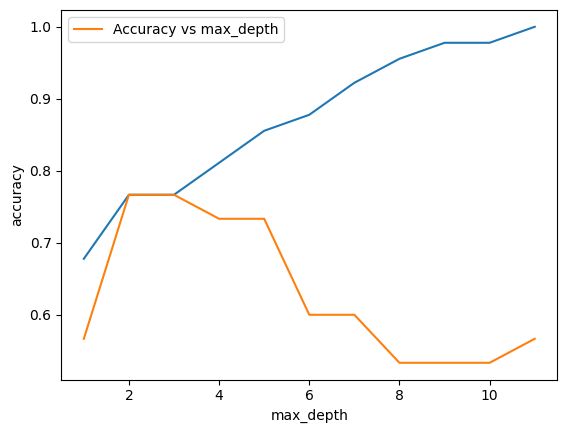

In [8]:
import matplotlib.pyplot as plt
 
max_depth_list = [i for i in range(1,12)]
x = np.arange(len(max_depth_list)) + 1 
plt.plot(x, training_accuracy)
plt.plot(x, testing_accuracy, label='Accuracy vs max_depth')
plt.xlabel('max_depth') 
plt.ylabel('accuracy') 
plt.legend() 
plt.show() 

##*The result from the above graph indicates that overfitting occurs from depth = 4 because there onwards the accuracy starts to decrease for the testing data against the increment in accuracy for the training data indicating that the model has adapted more to the training data such that it fails to evaluate unknown data resulting in a decrease of accuracy*

# BAGGING

In [9]:
df_train = df.iloc[:90, :]
df_test = df.iloc[90:, :]
actual = df.iloc[90:, -1].values

In [10]:
def accuracy_metric(actual, predicted):
        correct = 0
        for i in range(len(actual)):
            if actual[i] == predicted[i]:
                correct += 1
        return correct / float(len(actual)) * 100.0

In [11]:
bagging_iters=[10, 50, 100]
accuracy_of_iter=[]
for bag in bagging_iters:

    predictions=[]
    for i in range(bag):
        indexes = np.random.randint(low=0, high=df_train.shape[0], size=df_train.shape[0])
        dataset = df_train.iloc[indexes]
        tree = decision_tree_algorithm(dataset, "classification", counter=0, min_samples=1, max_depth=6)
        pred = make_predictions(df.iloc[90:,:-1], tree)
        predictions.append(pred.tolist())

    final_pred = []

    for j in range(len(predictions[0])): #0,30
        count_M=0
        count_W=0
        for i in range(len(predictions)): #0,1,2
            if predictions[i][j] == ' M ':
                count_M = count_M + 1
            else:
                count_W = count_W + 1

        if count_M >= count_W:
            final_pred.append(" M ")
        else:
            final_pred.append(" W ")

    ac = accuracy_metric(actual, final_pred)
    accuracy_of_iter.append(ac)

In [12]:
accuracy_of_iter

[66.66666666666666, 73.33333333333333, 73.33333333333333]

#### *From the above results of the three ensemble classifiers and comparing those with that of a single classifier with depth = 6 where we get the accuracy of 60%, we can infer that with the increase in bag size starting from the base size the accuracy keeps increasing with respect to that of the corresponding regular classifier (accuracy = 60%)*

# ADABOOST

In [13]:
df['g'] = np.where(df['g'] == ' M ', 0, 1)

In [14]:
X_train = df.iloc[:90, :-1].values
X_test = df.iloc[90:, :-1].values
y_train = df.iloc[:90, -1].values
y_test = df.iloc[90:, -1].values

In [15]:
class AdaBoost:
    
    def fit(self, X_train, y_train, T, stub_depth = 1):
        self.y_train = y_train
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.T = T
        self.stub_depth = stub_depth
        
        ## Instantiate stuff
        self.weights = np.repeat(1/self.N, self.N)
        self.trees = []
        self.alphas = []
        self.yhats = np.empty((self.N, self.T))
        self.yhat_t1 = []
        
        self.aa = []
        self.ab = []

        
        for t in range(self.T):
            
            self.yhat_t = []
            
            self.T_t = decision_tree_algorithm(df_train, "classification", counter=0, min_samples=2, max_depth=5)
            self.yhat_t1 = make_predictions(df_train, self.T_t).tolist()
            for i in range (len(self.yhat_t1)):
              if self.yhat_t1[i] == ' M ':
                self.yhat_t.append(1)
              else:
                self.yhat_t.append(0)


            # print("yhat_t", self.yhat_t)
            # print("length", len(self.yhat_t))
            # print("y_train",self.y_train)
            for i in range (len(y_train)):
              if (self.yhat_t[i] != self.y_train[i]):
                self.aa.append(1)
              else:
                self.aa.append(0)
            # print("aa", self.aa)
            # print("weights", self.weights)
            for i in range(len(y_train)):
              self.ab.append(self.aa[i]*self.weights[i])

            # print("ab", self.ab)
            self.epsilon_t = sum(self.ab)/sum(self.weights) 
            # print("epsilon", self.epsilon_t)

            # self.epsilon_t = sum(self.weights*(self.yhat_t != self.y_train))/sum(self.weights)
            self.alpha_t = np.log( (1-self.epsilon_t)/self.epsilon_t )
            # print("alpha", self.alpha_t)
            self.weights = np.array([w*(1-self.epsilon_t)/self.epsilon_t if self.yhat_t[i] != self.y_train[i]
                                    else w for i, w in enumerate(self.weights)])
            # print("upd wts", self.weights)
            ## Append stuff
            self.trees.append(self.T_t)
            # print("trees", self.trees)
            # print("datatype", type(self.trees))

            self.alphas.append(self.alpha_t)
            # print("alphas", self.alphas)
            # print("alphas type", type(self.alphas))
            self.yhats[:,t] = self.yhat_t 
            
        self.yhat = np.sign(np.dot(self.yhats, self.alphas))
        
    def predict(self, X_test):
        yhats = np.zeros(len(X_test))
        for t, tree in enumerate(self.trees):
            yhats_tree_list = []
            yhats_tree = make_predictions(df_test, tree).tolist()
            # print("yhats_tree", yhats_tree)
            for i in range (len(yhats_tree)):
              if yhats_tree[i] == ' M ':
                yhats_tree_list.append(1)
              else:
                yhats_tree_list.append(0)
            # print(yhats_tree_list)
            yhats += np.array(yhats_tree_list)*self.alphas[t]
        # print(yhats)
        # print(type(tree))
        return np.sign(yhats)

In [ ]:
for i in [10, 25, 50]:
    booster = AdaBoost()

    booster.fit(X_train, y_train, T = i, stub_depth = 8)
    yhat = booster.predict(X_test)
    print(np.mean(yhat == y_test))